# Hierarchical Relationships

## Import Data

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data_dir = Path('../..')/'data'/'sme_data'
df = pd.read_csv(data_dir/'MWOs_anon.csv')

df.date_received = pd.to_datetime(df.date_received)
print(f'There are {df.shape[0]} MWO\'s in this dataset')
# example data: 
df.loc[df.mach.str.contains('A\d|B\d', na=False),
       ['mach', 'date_received', 'issue', 'info', 'tech']].head(5)

There are 3438 MWO's in this dataset


,mach,date_received,issue,info,tech
0,A5,2015-01-14,No power,Replaced pin in pendant and powered machine -P...,"angie_henderson, michele_williams"
2,A18,2015-02-27,Check / Charge Accumulators,Where OK,nathan_maldonado
3,A23,2015-02-27,Hyd leak at saw atachment,Replaced seal in saw attachment but still leak...,michele_williams
4,A24,2015-02-27,CS1008 setup change over / from ARC1004,Completed / Threading unit rewired,"ethan_adams, michele_williams"
5,A27,2015-02-27,Gears on saw attachment tight and grinding per...,Replaced saw attachment with rebuilt unit / Re...,michele_williams


In [4]:
from nestor import keyword as kex
# merge and cleanse NLP-containing columns of the data
nlp_select = kex.NLPSelect(columns = ['issue', 'info'])
raw_text = nlp_select.transform(df)

vocab = pd.read_csv(data_dir/'vocab.csv' , index_col=0)
vocab2 = pd.read_csv(data_dir/'2g_vocab.csv', index_col=0)

tag_df, tag_relation, NA_df = kex.ngram_keyword_pipe(raw_text, vocab, vocab2)  


intialized successfully!



intialized successfully!


## Build Hierarchy (Heymann's Taxonomy)

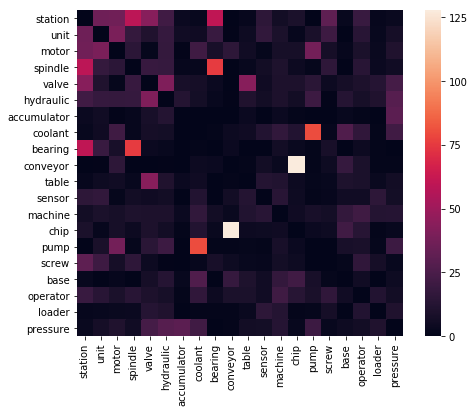

In [17]:
from nestor.tagtrees import node_adj_mat, tag_network, tag_df_network, heymann_taxonomy

tag_similarity = node_adj_mat(tag_df["I"])

plt.figure(figsize=(8,6))
sns.heatmap(200*tag_similarity.iloc[:20,:20], square=True)


In [20]:
from nestor.tagtrees import heymann_taxonomy
D = heymann_taxonomy(tag_similarity.iloc[:100,:100], dynamic=False, verbose=False, tau=8e-2);


100%|██████████| 100/100 [00:00<00:00, 968.43it/s]

unit


5


/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


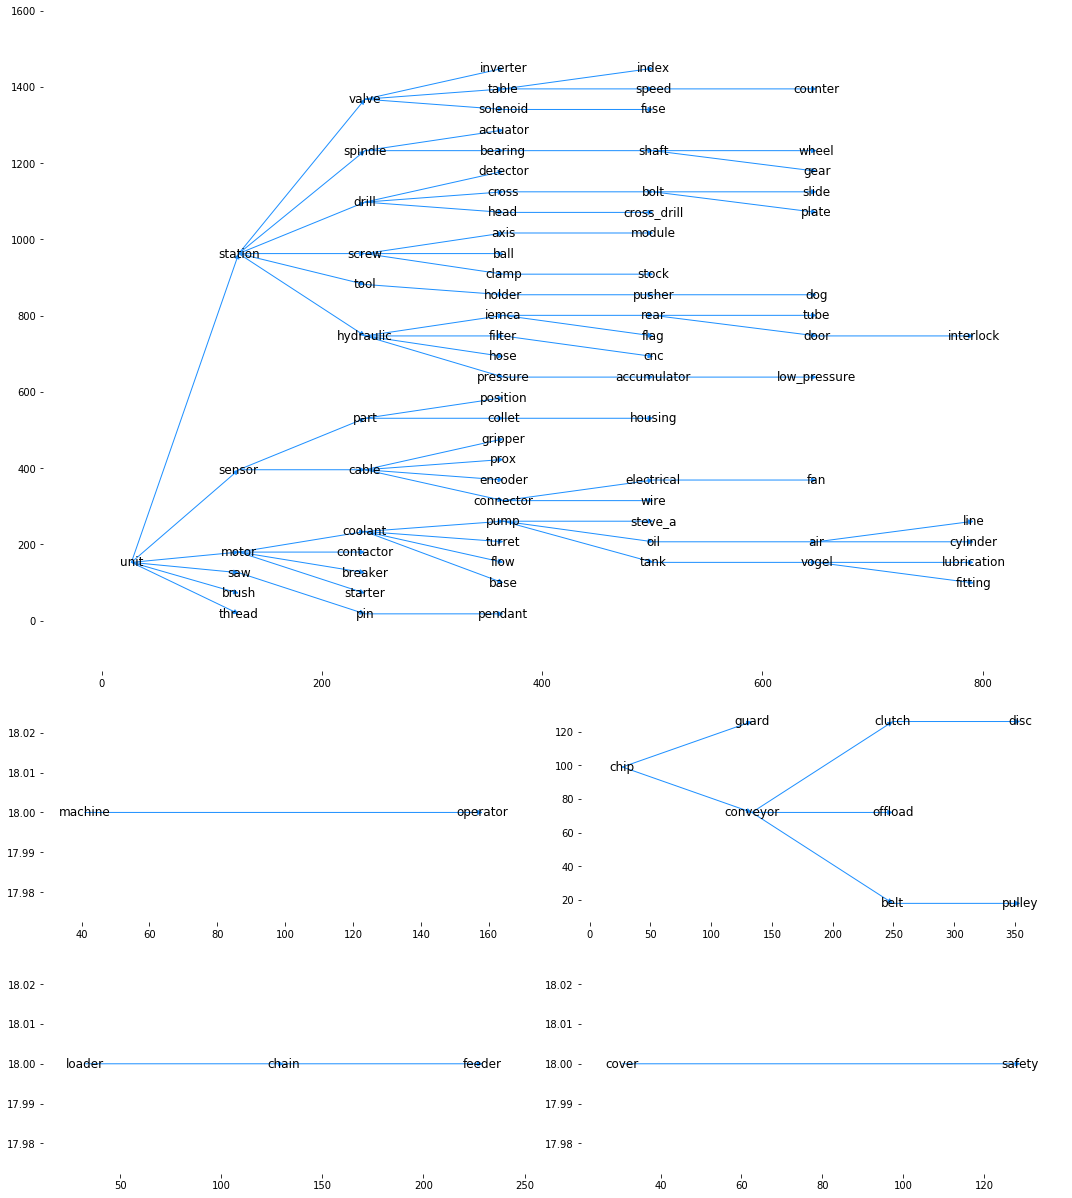

In [22]:
import matplotlib.gridspec as gridspec
import networkx as nx
D.graph.setdefault('graph', {})['rankdir'] = 'LR'

subg = list(nx.weakly_connected_component_subgraphs(D))
fig = plt.figure(tight_layout=True, figsize=(15,20))
n_rows = 1+len(subg)//2+len(subg)%2
print(len(subg))
gs = gridspec.GridSpec(n_rows, 2, 
                       height_ratios=[3]+(n_rows-1)*[1])

for n, d in enumerate(subg):
    if n==0:
        ax = fig.add_subplot(gs[:n+1, :])
    else:
        ax = fig.add_subplot(gs[(n+1)//2, (n+1)%2])
    nx.draw_networkx(d, ax=ax,
                     pos=nx.drawing.nx_pydot.pydot_layout(d, prog='dot'),
                     node_size=0,edge_color='dodgerblue')
    sns.despine(left=True, bottom=True)

## D3 Collapsible Tree

In [41]:
from networkx.readwrite import json_graph
from networkx.algorithms.traversal.depth_first_search import dfs_tree
import json

subD = dfs_tree(D, 'station')

with open('d3tree.json', 'w') as outfile:
    s=json.dump(json_graph.tree.tree_data(subD, 'station'), outfile)

In [42]:
%%writefile f2.template
<!DOCTYPE html>
<meta charset="utf-8">
<style>

.node {
  cursor: pointer;
}

.node circle {
  fill: #fff;
  stroke: steelblue;
  stroke-width: 1.5px;
}

.node text {
  font: 10px sans-serif;
}

.link {
  fill: none;
  stroke: #ccc;
  stroke-width: 1.5px;
}

</style>
<body>
<script src="//d3js.org/d3.v3.min.js"></script>
<script>

var margin = {top: 20, right: 120, bottom: 20, left: 120},
    width = 1400 - margin.right - margin.left,
    height = 900 - margin.top - margin.bottom;

var i = 0,
    duration = 750,
    root;

var tree = d3.layout.tree()
    .size([height, width]);

var diagonal = d3.svg.diagonal()
    .projection(function(d) { return [d.y, d.x]; });

var svg = d3.select("body").append("svg")
    .attr("width", width + margin.right + margin.left)
    .attr("height", height + margin.top + margin.bottom)
  .append("g")
    .attr("transform", "translate(" + margin.left + "," + margin.top + ")");

d3.json("d3tree.json", function(error, flare) {
  if (error) throw error;

  root = flare;
  root.x0 = height / 2;
  root.y0 = 0;

  function collapse(d) {
    if (d.children) {
      d._children = d.children;
      d._children.forEach(collapse);
      d.children = null;
    }
  }

  root.children.forEach(collapse);
  update(root);
});

d3.select(self.frameElement).style("height", "1200px");

function update(source) {

  // Compute the new tree layout.
  var nodes = tree.nodes(root).reverse(),
      links = tree.links(nodes);

  // Normalize for fixed-depth.
  nodes.forEach(function(d) { d.y = d.depth * 180; });

  // Update the nodes…
  var node = svg.selectAll("g.node")
      .data(nodes, function(d) { return d.id || (d.id = ++i); });

  // Enter any new nodes at the parent's previous position.
  var nodeEnter = node.enter().append("g")
      .attr("class", "node")
      .attr("transform", function(d) { return "translate(" + source.y0 + "," + source.x0 + ")"; })
      .on("click", click);

  nodeEnter.append("circle")
      .attr("r", 1e-6)
      .style("fill", function(d) { return d._children ? "lightsteelblue" : "#fff"; });

  nodeEnter.append("text")
      .attr("x", function(d) { return d.children || d._children ? -10 : 10; })
      .attr("dy", ".35em")
      .attr("text-anchor", function(d) { return d.children || d._children ? "end" : "start"; })
      .text(function(d) { return d.id; })
      .style("fill-opacity", 1e-6);

  // Transition nodes to their new position.
  var nodeUpdate = node.transition()
      .duration(duration)
      .attr("transform", function(d) { return "translate(" + d.y + "," + d.x + ")"; });

  nodeUpdate.select("circle")
      .attr("r", 4.5)
      .style("fill", function(d) { return d._children ? "lightsteelblue" : "#fff"; });

  nodeUpdate.select("text")
      .style("fill-opacity", 1);

  // Transition exiting nodes to the parent's new position.
  var nodeExit = node.exit().transition()
      .duration(duration)
      .attr("transform", function(d) { return "translate(" + source.y + "," + source.x + ")"; })
      .remove();

  nodeExit.select("circle")
      .attr("r", 1e-6);

  nodeExit.select("text")
      .style("fill-opacity", 1e-6);

  // Update the links…
  var link = svg.selectAll("path.link")
      .data(links, function(d) { return d.target.id; });

  // Enter any new links at the parent's previous position.
  link.enter().insert("path", "g")
      .attr("class", "link")
      .attr("d", function(d) {
        var o = {x: source.x0, y: source.y0};
        return diagonal({source: o, target: o});
      });

  // Transition links to their new position.
  link.transition()
      .duration(duration)
      .attr("d", diagonal);

  // Transition exiting nodes to the parent's new position.
  link.exit().transition()
      .duration(duration)
      .attr("d", function(d) {
        var o = {x: source.x, y: source.y};
        return diagonal({source: o, target: o});
      })
      .remove();

  // Stash the old positions for transition.
  nodes.forEach(function(d) {
    d.x0 = d.x;
    d.y0 = d.y;
  });
}

// Toggle children on click.
function click(d) {
  if (d.children) {
    d._children = d.children;
    d.children = null;
  } else {
    d.children = d._children;
    d._children = null;
  }
  update(d);
}

</script>

Writing f2.template


In [43]:
from IPython.display import IFrame
import re

def replace_all(txt,d):
    rep = dict((re.escape('{'+k+'}'), str(v)) for k, v in d.items())
    pattern = re.compile("|".join(rep.keys()))
    return pattern.sub(lambda m: rep[re.escape(m.group(0))], txt)    

count=0
def serve_html(s,w,h):
    import os
    global count
    count+=1
    fn= '__tmp'+str(os.getpid())+'_'+str(count)+'.html'
    with open(fn,'w') as f:
        f.write(s)
    return IFrame('files/'+fn,w,h)

def f2(w=500,h=400):
    d={
       'width'      :w,
       'height'     :h,
       }
    with open('f2.template','r') as f:
        s=f.read()
    s= replace_all(s,d)        
    return serve_html(s,w+30,h+30)

In [44]:
f2(w=800,h=800)